<a href="https://colab.research.google.com/github/Zulfahanamaulida/TA_Deteksi-Residu-Pestisida/blob/main/Percobaan_2_Arsitektur_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data input : Data image binary dari citra 0 (without_pesticide) dan 10 (with_pesticide) mg/l | Tanpa ROI

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from keras.callbacks import EarlyStopping
from google.colab import drive

In [3]:
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Define the path to the directory containing the dataset
dataset_path = '/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Dataset/Image/Binary/'

Class: with_pesticide - Number of data points: 150
Class: without_pesticide - Number of data points: 150
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)    

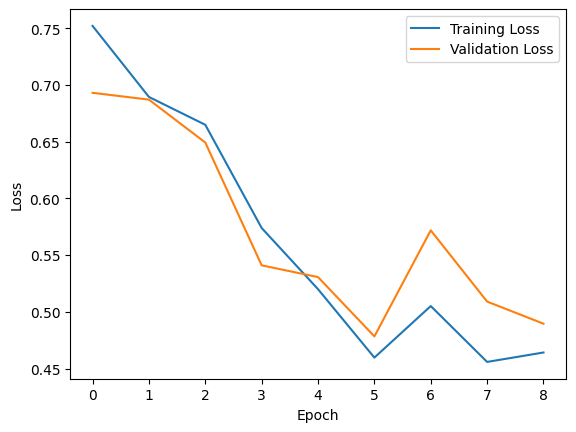

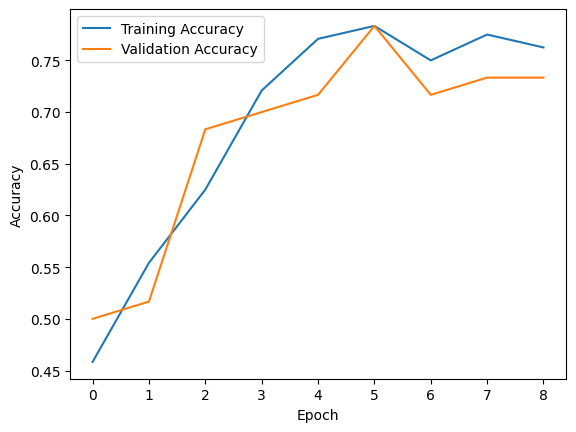

In [8]:
# Load images and labels
X = []
y = []
class_counts = {}  # Dictionary to store counts for each class

for class_idx, class_folder in enumerate(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        class_name = class_folder
        class_count = 0  # Initialize count for the current class
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)  # Read image
            img = cv2.resize(img, (28, 28))  # Resize image to 28x28
            X.append(img)
            y.append(class_idx)
            class_count += 1  # Increment count for the current class
        class_counts[class_name] = class_count  # Store count for the current class

X = np.array(X)
y = np.array(y)

# Print class names and number of data points in each class
for class_name, count in class_counts.items():
    print("Class:", class_name, "- Number of data points:", count)

# Normalize pixel values to range [0, 1]
X = X.astype('float32') / 255.0

# Reshape data to fit the CNN input shape (assuming grayscale images)
X = X.reshape(-1, 28, 28, 3)

# Convert labels to categorical one-hot encoding
y = to_categorical(y)

# Split data into train and test sets for each class
X_train_class = []
X_test_class = []
y_train_class = []
y_test_class = []

for class_idx in range(len(class_counts)):
    class_indices = np.where(y[:, class_idx] == 1)[0]
    X_class = X[class_indices]
    y_class = y[class_indices]
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)
    X_train_class.append(X_train_c)
    X_test_class.append(X_test_c)
    y_train_class.append(y_train_c)
    y_test_class.append(y_test_c)

# Concatenate the splits for each class
X_train = np.concatenate(X_train_class, axis=0)
X_test = np.concatenate(X_test_class, axis=0)
y_train = np.concatenate(y_train_class, axis=0)
y_test = np.concatenate(y_test_class, axis=0)

# Shuffle the training data
shuffle_index = np.random.permutation(len(X_train))
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Shuffle the test data
shuffle_index = np.random.permutation(len(X_test))
X_test, y_test = X_test[shuffle_index], y_test[shuffle_index]

# Define the model architecture
def VGG_16(_input = Input((28,28,3))):
    # Block 1
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu')(_input)
    conv2 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv2)
    # Block 2
    conv3 = Conv2D(64, (3, 3), padding='same', activation='relu')(pool1)
    conv4 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv3)
    pool2 = MaxPooling2D((2, 2))(conv4)
    # Fully Connected layers
    flat = Flatten()(pool2)
    dense1 = Dense(256, activation='relu')(flat)
    dense2 = Dense(128, activation='relu')(dense1)
    output = Dense(len(class_counts), activation='softmax')(dense2)  # Adjust output units according to the number of classes
    VGG16_model = Model(inputs=_input, outputs=output)
    return VGG16_model

# Instantiate the model
model = VGG_16()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=3)])
train_loss = history.history['loss'][-1]
train_accuracy = history.history['accuracy'][-1]
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 [==============================] - 0s 29ms/step


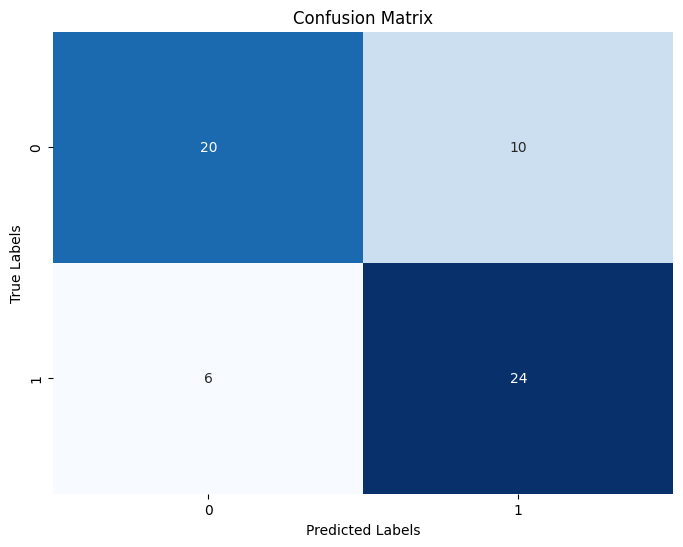

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.67      0.71        30
           1       0.71      0.80      0.75        30

    accuracy                           0.73        60
   macro avg       0.74      0.73      0.73        60
weighted avg       0.74      0.73      0.73        60



In [9]:
# Evaluate the model on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_true_classes, y_pred_classes)

# Print classification report
print("Classification Report:\n", class_report)
